In [2]:
!nvidia-smi | grep "Tesla"

|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |


In [3]:
import pandas as pd


clk = pd.read_csv('processed_data.csv', sep = '|')
clk.head()

,timestamp,date,hour,aux_hour,price,volume,side,avg_price_by_hour,std_price_by_hour
0,2021-04-24 00:00:07.440,2021-04-24,00:00:07,0,29.19000,60.36,sell,28.237243,0.434915
1,2021-04-24 00:00:09.953,2021-04-24,00:00:09,0,29.19000,45.64,sell,28.237243,0.434915
2,2021-04-24 00:00:16.813,2021-04-24,00:00:16,0,29.18802,30.70,buy,28.237243,0.434915
3,2021-04-24 00:00:20.042,2021-04-24,00:00:20,0,29.20000,20.00,sell,28.237243,0.434915
4,2021-04-24 00:00:20.386,2021-04-24,00:00:20,0,29.22945,0.23,sell,28.237243,0.434915


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
v_sc = scaler.fit_transform(clk[['price']].values)

import numpy as np
import matplotlib.pyplot as plt

def make_simple_rolling_window(data, window: int):
    X,Y = [],[]
    for i in range(len(data)-window-1):
        X.append(data[i:(i+window),0])
        Y.append(data[(i+window),0])
    return np.array(X),np.array(Y)

x_w, y_w = make_simple_rolling_window(v_sc, window = 5)
cut = int(0.85*x_w.shape[0])

x_train, x_test = x_w[0:cut], x_w[cut:]
y_train, y_test = y_w[0:cut], y_w[cut:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((84983, 5), (14997, 5), (84983,), (14997,))

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

class reduce_prints(tf.keras.callbacks.Callback):
    '''Function that will tell us wether the model is learning or not eventhough verbose is set to 0 in order
    to reduce prints and nb text'''
    def __init__(self, epochs):
        self.epochs = epochs
        print(f" Printing out results every {epochs} epochs")
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epochs ==0:
            print('Epoch {}: Average loss is {}, mean absolute error is {}.'.format(epoch, logs['loss'], logs['val_loss']))

def show_train(history):
    '''Function to display training process for model'''
    plt.figure(figsize=(5,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model MSE')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    print(" ")
    plt.figure(figsize=(5,3))
    plt.plot(history.history['lr'])
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


def test_model_diff_seqs(model, events_to_forecast: int, seqs: list):
  for seq in seqs:
    print(f" Testing performance in seq ---> {seq}")
    current_seq = x_test[seq]
    predicted, real, l_errors, l_maes = list(), list(), list(), list()
    for obs in range(events_to_forecast):
        pred = model.predict(current_seq.reshape(1, 5))[0]
        predicted.append(pred[0])
        real.append(y_test[seq])
        l_errors.append(abs(pred - y_test[seq]))
        seq += 1
        current_seq = np.concatenate([x_test[seq][:-1], pred])
    mae_error = np.array(l_errors).mean()
    l_maes.append(mae_error)
    print(f"MAE error on seq {seq} ---> ", mae_error)
    plt.plot(predicted, linewidth = 2)
    plt.plot(real, linewidth = 2)
    plt.title('Predicted vs Real Crypto To ' + str(events_to_forecast) + ' Events')
    plt.legend(['Predicted_values', 'Real_values'])
    plt.show()
  print(f" Mean MAE over the sequences and overall performance ---> {np.mean(l_maes)}")

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, restore_best_weights=True)
reducelr = ReduceLROnPlateau(monitor = 'val_loss', patience = 12, verbose = 1, factor = 0.5, min_lr = 1e-9)
cbs = [reducelr, early_stopping, reduce_prints(20)]

 Printing out results every 20 epochs


### 2.2.- RNNs. Vanilla LSTM layer.

Recurrent neural networks (RNN) are a class of neural networks that is powerful for modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far.

This layers are supossed to perform better using multiple timesteps. We are going to use 4 as window lenght

inputs: A 3D tensor with shape [batch, timesteps, feature].

We are on a univariate time series problem, so feature = 1 and timesteps are the columns of our data and batch is equal to our data lenght, but this param does not need to be specified.

this LSTM implementation defaultly has

activation="tanh",
recurrent_activation="sigmoid",

In [6]:
import keras
from tensorflow.keras.layers import LSTM, Dense, Input


inputs = Input(shape = (x_train.shape[1],1))
lstm1 = LSTM(256, activation= 'relu', return_sequences=False)(inputs)
outputs = Dense(1, activation = 'relu')(lstm1)

model_v_lstm = keras.Model(inputs=inputs, outputs=outputs, name='dense_model')
opt = keras.optimizers.Nadam(lr=0.0001)
model_v_lstm.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_v_lstm = model_v_lstm.fit(x_train, y_train, validation_split=0.225, verbose = 0,  epochs = 100, callbacks=cbs)




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.08708164095878601, mean absolute error is 3.092847327934578e-05.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 20: Average loss is 4.511813585850177e-06, mean absolute error is 1.4735232980456203e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 40: Average loss is 4.082874966115924e-06, mean absolute error is 3.4216660424135625e-05.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping


 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0043066395


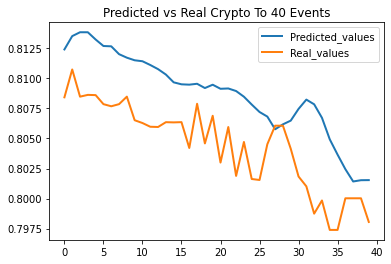

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0043969513


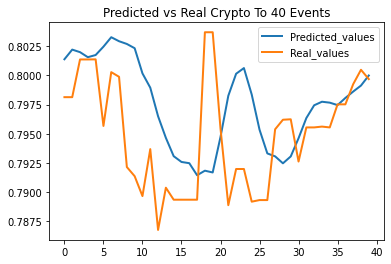

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0041890787


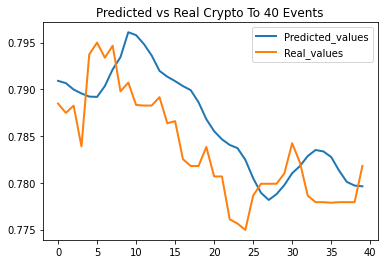

 Mean MAE over the sequences and overall performance ---> 0.004189078696072102


In [7]:
test_model_diff_seqs(model_v_lstm, 40, [20, 60, 120])

In [8]:
import time
t0 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
lstm1 = LSTM(256, activation= 'tanh', return_sequences=False)(inputs)
outputs = Dense(1, activation = 'relu')(lstm1)

model_v_lstm_tanh = keras.Model(inputs=inputs, outputs=outputs, name='dense_model')
opt = keras.optimizers.Nadam(lr=0.00001)
model_v_lstm_tanh.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_v_lstm_tanh = model_v_lstm_tanh.fit(x_train, y_train, validation_split=0.225, verbose = 1, epochs = 100, callbacks=cbs)

print(time.time()- t0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2059/2059 [==============================] - 15s 5ms/step - loss: 0.0366 - mean_absolute_error: 0.1396 - val_loss: 6.0225e-04 - val_mean_absolute_error: 0.0239
Epoch 0: Average loss is 0.013399324379861355, mean absolute error is 0.0006022517918609083.
Epoch 2/100
2059/2059 [==============================] - 11s 5ms/step - loss: 2.3389e-04 - mean_absolute_error: 0.0111 - val_loss: 6.0618e-04 - val_mean_absolute_error: 0.0195
Epoch 3/100
2059/2059 [==============================] - 10s 5ms/step - loss: 2.5404e-05 - mean_absolute_error: 0.0040 - val_loss: 4.8772e-04 - val_mean_absolute_error: 0.0177
Epoch 4/100
2059/2059 [==============================] - 11s 5ms/step - loss: 1.9425e-05 - mean_absolute_error: 0.0035 - val_loss: 2.5658e-04 - val_mean_absolute_error: 0.0129
Epoch 5/100
2059/2059 [==============================] - 10s 5ms/step - loss: 1.2577e-05 - mean_absolute_error: 0.0028 - val_loss: 9.2608e-05 - val_mean_absolute_error: 0.0077
Epoch 6/100
2059/2059 [========

 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0015648932


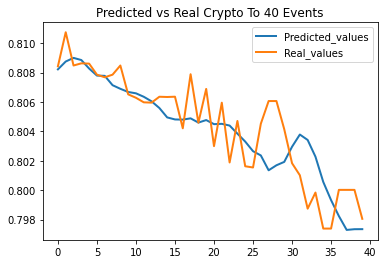

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0038621859


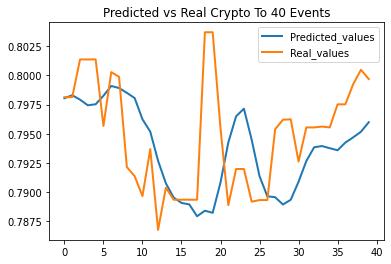

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0029908225


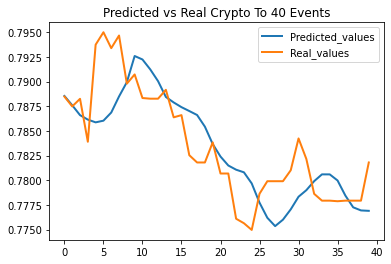

 Mean MAE over the sequences and overall performance ---> 0.0029908225405961275


In [9]:
test_model_diff_seqs(model_v_lstm_tanh, 40, [20, 60, 120])

It is clear that the activation function should be tanh which is the value by default, although I would expect the difference to be higher.

Let us test another Recurrent Layer. GRUs. These are said to train faster, remember shorter sequences and their performance is said to be very similar to LSTMs.


GATE RECURRENT UNIT

In [10]:
from tensorflow.keras.layers import GRU

t0 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
gru1 = GRU(256, activation= 'tanh', return_sequences=False)(inputs)
outputs = Dense(1, activation = 'relu')(gru1)

model_gru = keras.Model(inputs=inputs, outputs=outputs, name='dense_model')
opt = keras.optimizers.Nadam(lr=0.00001)
model_gru.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_gru = model_gru.fit(x_train, y_train, validation_split=0.225, verbose = 1, epochs = 100, callbacks=cbs)

print(time.time()- t0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2059/2059 [==============================] - 13s 5ms/step - loss: 0.0357 - mean_absolute_error: 0.1352 - val_loss: 5.6541e-04 - val_mean_absolute_error: 0.0229
Epoch 0: Average loss is 0.012542384676635265, mean absolute error is 0.0005654069245792925.
Epoch 2/100
2059/2059 [==============================] - 10s 5ms/step - loss: 1.3333e-04 - mean_absolute_error: 0.0081 - val_loss: 2.8527e-04 - val_mean_absolute_error: 0.0135
Epoch 3/100
2059/2059 [==============================] - 10s 5ms/step - loss: 1.3330e-05 - mean_absolute_error: 0.0029 - val_loss: 2.0706e-04 - val_mean_absolute_error: 0.0114
Epoch 4/100
2059/2059 [==============================] - 10s 5ms/step - loss: 1.1218e-05 - mean_absolute_error: 0.0026 - val_loss: 1.2836e-04 - val_mean_absolute_error: 0.0089
Epoch 5/100
2059/2059 [==============================] - 10s 5ms/step - loss: 8.7883e-06 - mean_absolute_error: 0.0023 - val_loss: 7.3764e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
2059/2059 [========

 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0014935508


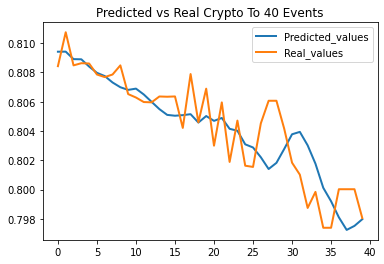

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.003657709


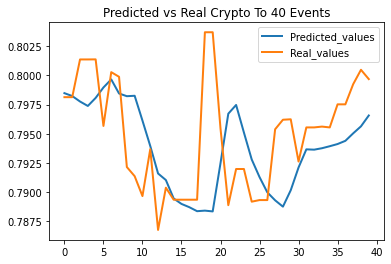

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0029267415


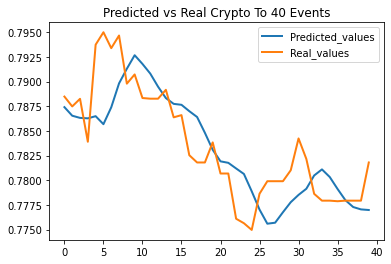

 Mean MAE over the sequences and overall performance ---> 0.0029267414938658476


In [11]:
test_model_diff_seqs(model_gru, 40, [20, 60, 120])

 We see that although GRUs have 1 less gate and fewer computations it takes same time by epoch. Perhaps we would see differences if we were using CPUs instead of GPUs and working with higher amounts of data. In terms of performance it works slightly better.
 To end up with "simple" Recurrent Layers we will give a try to Bidirectional LTSMs. These are pretty used nowadays on NLP problems because words are affected by surrounding context, not only by the words at the left, but also by the right context words. 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.009935674257576466, mean absolute error is 0.00023562443675473332.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 20: Average loss is 3.956612999900244e-06, mean absolute error is 7.264608939294703e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 40: Average loss is 3.7096838241268415e-06, mean absolute error is 7.631775588379242e-06.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 60: Average loss is 3.623535576480208e-06, mean absolute error is 7.293431735888589e-06.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.
Epoch 80: Average loss is 3.595239604692324e-06, mean absolute error is 7.06217633705819e-06.
Restoring model weights from the end of the

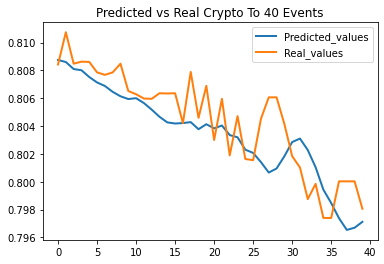

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.003933753


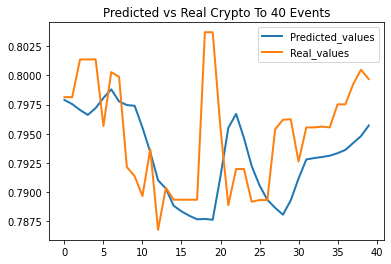

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0029192357


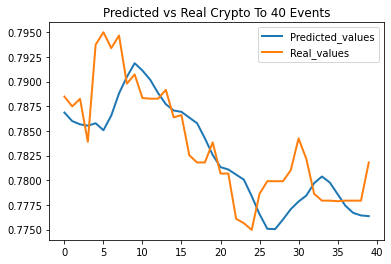

 Mean MAE over the sequences and overall performance ---> 0.002919235732406378


In [21]:
from tensorflow.keras.layers import Bidirectional


t0 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
bilstm = Bidirectional(LSTM(256, return_sequences=False, activation= 'tanh'))(inputs)
outputs = Dense(1, activation = 'relu')(bilstm)

model_bi = keras.Model(inputs=inputs, outputs=outputs, name='dense_model')
opt = keras.optimizers.Nadam(lr=0.00001)
model_bi.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_bi = model_bi.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)

print(time.time()- t0)

test_model_diff_seqs(model_bi, 40, [20, 60, 120])

 Let us review what happens when we stack several LSTMs layers. Remember that we need to set the return_seq param to True in order to also pass the cell states between the RNNs

In [13]:
import time
t1 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
lstm1 = LSTM(256, activation= 'tanh', return_sequences=True)(inputs)
lstm2 = LSTM(128, activation= 'tanh', return_sequences=False)(lstm1)
outputs = Dense(1, activation = 'relu')(lstm2)

model_stck_lstm = keras.Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.00001)
model_stck_lstm.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_stck_lstm  = model_stck_lstm.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)

test_scores = model_stck_lstm.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
print("Elapsed training time", time.time()- t1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.011112675070762634, mean absolute error is 0.00036244839429855347.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 20: Average loss is 5.750502168666571e-06, mean absolute error is 1.0379561899753753e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 40: Average loss is 5.611308097286383e-06, mean absolute error is 1.196249922941206e-05.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 60: Average loss is 5.569862878473941e-06, mean absolute error is 1.0520584510231856e-05.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
469/469 - 1s - loss: 2.2225e-05 - mean_absolute_error: 0.0039
Test loss: 2.222520015493501e-05
Test accuracy: 0.0038734241388738155


 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0017251566


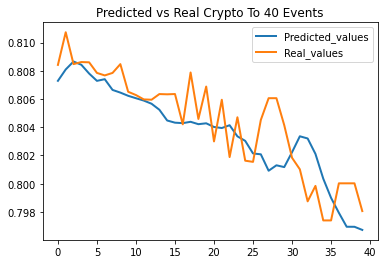

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0040633036


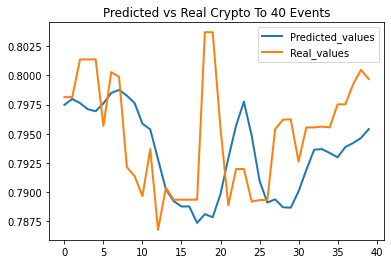

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0030492097


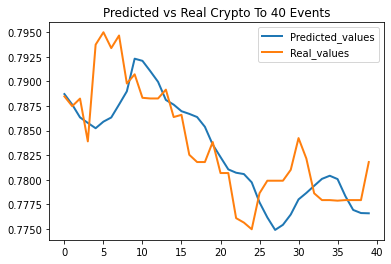

 Mean MAE over the sequences and overall performance ---> 0.003049209713935852


In [14]:
test_model_diff_seqs(model_stck_lstm, 40, [20, 60, 120])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.06619945913553238, mean absolute error is 0.09883180260658264.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
Epoch 20: Average loss is 5.238776793703437e-06, mean absolute error is 2.5670193281257525e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.2499999968440534e-07.
Epoch 40: Average loss is 4.373327101347968e-06, mean absolute error is 8.33878766570706e-06.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 6.249999984220267e-08.
Epoch 60: Average loss is 4.303829882701393e-06, mean absolute error is 7.5357679634180386e-06.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 3.1249999921101335e-08.

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.5624999960550667e-08.
Epoch 80: Average loss is 4.287099272914929e-06, mean absolute error is 7.460690085281385e-06.

Epoch 00088: ReduceLROnPlateau reducing

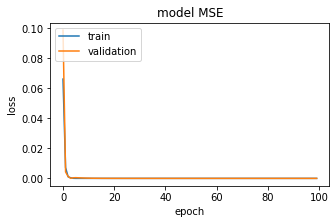

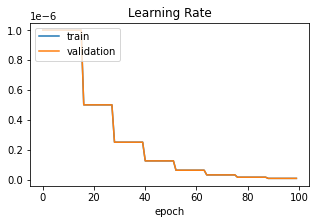

469/469 - 1s - loss: 8.5311e-06 - mean_absolute_error: 0.0022
Test loss: 8.531070307071786e-06
Test accuracy: 0.0021705462131649256
Elapsed training time 13206.635853528976
 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0018974111


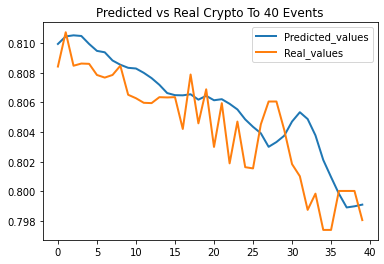

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0036872863


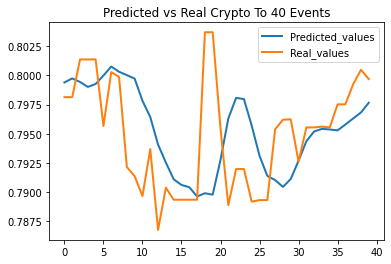

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.003356643


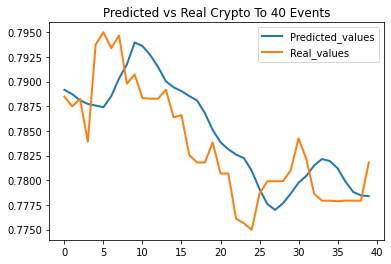

 Mean MAE over the sequences and overall performance ---> 0.00335664302110672


In [24]:

inputs = Input(shape = (x_train.shape[1],1))
bilstm = Bidirectional(LSTM(256, return_sequences=True, activation= 'tanh'))(inputs)
lstm2 = LSTM(128, activation= 'tanh', return_sequences=False)(bilstm)
outputs = Dense(1, activation = 'relu')(lstm2)

model_bi_stck = keras.Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.000001)
model_bi_stck.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_bi_stck  = model_bi_stck.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)

show_train(history=history_bi_stck)
test_scores = model_bi_stck.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
print("Elapsed training time", time.time()- t1)

test_model_diff_seqs(model_bi_stck, 40, [20, 60, 120])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.014873839914798737, mean absolute error is 0.0020324375946074724.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 20: Average loss is 6.614887752220966e-06, mean absolute error is 2.9595737942145206e-05.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
469/469 - 1s - loss: 2.2442e-05 - mean_absolute_error: 0.0038
Test loss: 2.2441709006670862e-05
Test accuracy: 0.00382442120462656
Elapsed training time 627.9503903388977
 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0051818104


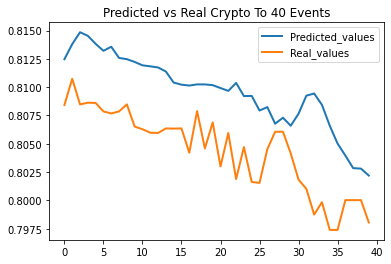

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0053700893


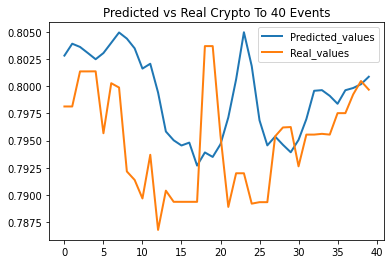

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.0056683226


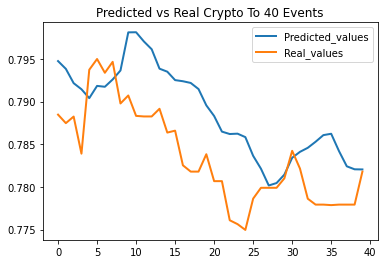

 Mean MAE over the sequences and overall performance ---> 0.005668322555720806


In [15]:
import time
t1 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
lstm1 = LSTM(256, activation= 'tanh', return_sequences=True)(inputs)
lstm2 = LSTM(128, activation= 'tanh', return_sequences=True)(lstm1)
lstm3 = LSTM(64, activation= 'tanh', return_sequences=False)(lstm2)
outputs = Dense(1, activation = 'relu')(lstm3)

model_stck_2lstm = keras.Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.00001)
model_stck_2lstm.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

history_stck_2lstm  = model_stck_2lstm.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)

test_scores = model_stck_2lstm.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
print("Elapsed training time", time.time()- t1)

test_model_diff_seqs(model_stck_2lstm, 40, [20, 60, 120])

As we can see if we stack LSTMs layers we do not obtain better performance and the more layers we stack, the worse the performance. So it is not worth it keep exploring this way. 

Last kind of layers we are testing are CNNs, which besides of being the de facto standard in image problems are also applied to Time Series.


## Convolutional Neural Network

It also takes multiple time steps as input to each prediction.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 256)            1024      
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 256)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
___________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 0: Average loss is 0.005486584268510342, mean absolute error is 0.001189392409287393.
Epoch 20: Average loss is 5.972719463898102e-06, mean absolute error is 0.000814806844573468.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 40: Average loss is 5.522085302800406e-06, mean absolute error is 0.0007496392936445773.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 60: Average loss is 5.297802090353798e-06, mean absolute error is 0.0007193056517280638.
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
399.12123918533325
 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0536638


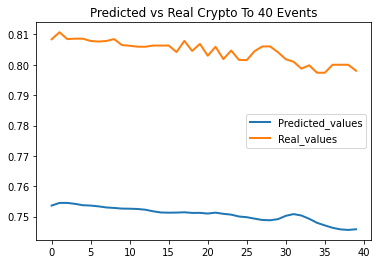

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.051804222


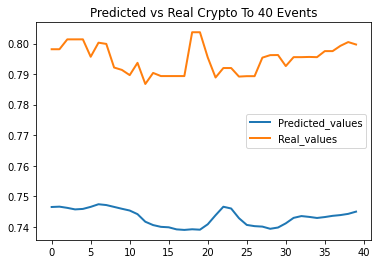

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.048143983


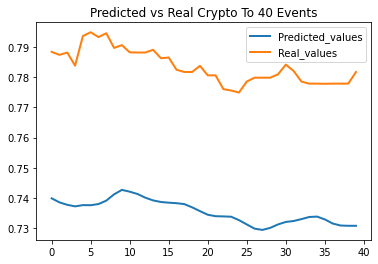

 Mean MAE over the sequences and overall performance ---> 0.048143982887268066


In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D
from tensorflow.keras import Model
t0 = time.time()

inputs = Input(shape = (x_train.shape[1],1))
cnn1 = Conv1D(filters = 256, kernel_size=3, activation = 'relu', padding='same')(inputs)
avg = AveragePooling1D(pool_size=3)(cnn1)
flat1 = Flatten()(avg)
d1 = Dense(32, activation='relu')(flat1)
outputs = Dense(1, activation = 'relu')(d1)

model_cnn1 = Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.0001)
model_cnn1.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

model_cnn1.summary()

history_cnn1 = model_cnn1.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)

print(time.time()- t0)


test_model_diff_seqs(model_cnn1, 40, [20, 60, 120])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 5, 1)]            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 256)            1024      
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 256)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_____________________________________________________

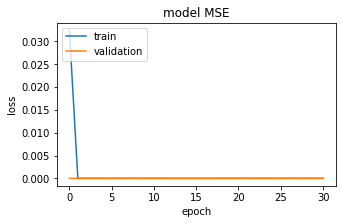

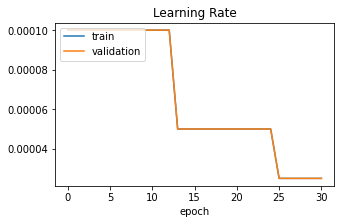

 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.0018960834


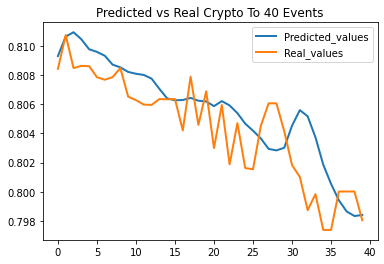

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.0038030923


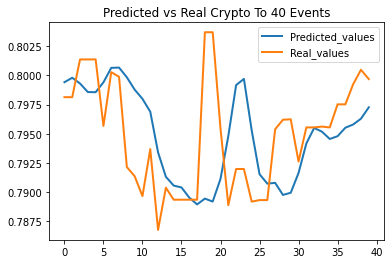

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.00330901


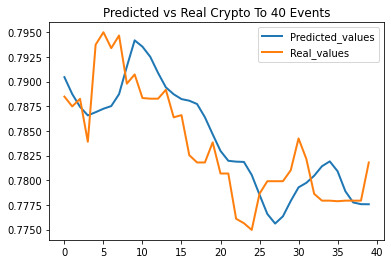

 Mean MAE over the sequences and overall performance ---> 0.003309010062366724


In [26]:
inputs = Input(shape = (x_train.shape[1],1))
cnn1 = Conv1D(filters = 256, kernel_size=3, activation = 'relu', padding='same')(inputs)
avg = AveragePooling1D(pool_size=3)(cnn1)
lstm = LSTM(128, activation= 'tanh', return_sequences=False)(avg)
d1 = Dense(32, activation='relu')(lstm)
outputs = Dense(1, activation = 'relu')(d1)

model_cnn1_lstm = Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.0001)
model_cnn1_lstm.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

model_cnn1_lstm.summary()

history_cnn1_lstm = model_cnn1_lstm.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)
show_train(history_cnn1_lstm)

test_model_diff_seqs(model_cnn1_lstm, 40, [20, 60, 120])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 5, 1)]            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 256)            1024      
_________________________________________________________________
average_pooling1d_5 (Average (None, 1, 256)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense_24 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 1,068,097
Trainable params: 1,068,097
Non-trainable params: 0
_________________________________________________

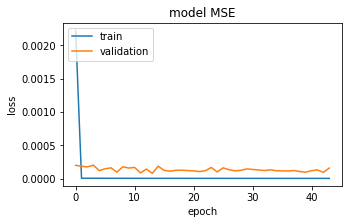

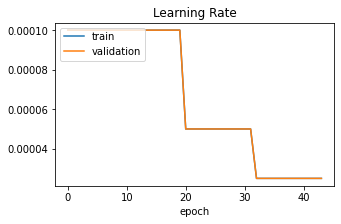

 Testing performance in seq ---> 20
MAE error on seq 60 --->  0.01653635


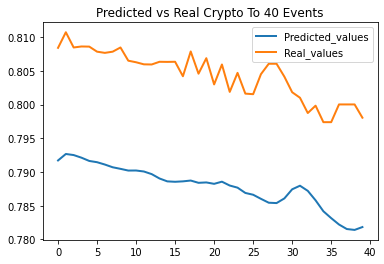

 Testing performance in seq ---> 60
MAE error on seq 100 --->  0.016606504


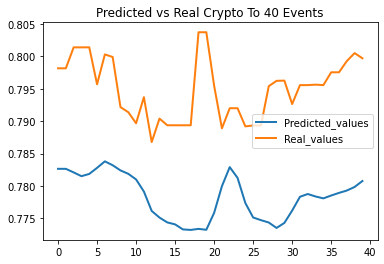

 Testing performance in seq ---> 120
MAE error on seq 160 --->  0.014919793


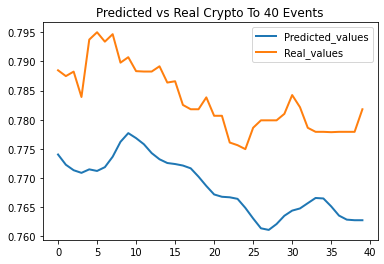

 Mean MAE over the sequences and overall performance ---> 0.014919793233275414


In [30]:
inputs = Input(shape = (x_train.shape[1],1))
cnn1 = Conv1D(filters = 256, kernel_size=3, activation = 'relu', padding='same')(inputs)
avg = AveragePooling1D(pool_size=3)(cnn1)
bilstm = Bidirectional(LSTM(256, return_sequences=False, activation= 'tanh'))(avg)
d1 = Dense(32, activation='relu')(bilstm)
outputs = Dense(1, activation = 'relu')(d1)

model_cnn1_bilstm = Model(inputs=inputs, outputs=outputs)
opt = keras.optimizers.Nadam(lr=0.0001)
model_cnn1_bilstm.compile(loss='mean_squared_error', 
              optimizer=opt, metrics=["mean_absolute_error"])

model_cnn1_bilstm.summary()

history_cnn1_bilstm = model_cnn1_bilstm.fit(x_train, y_train, validation_split=0.225, verbose = 0, epochs = 100, callbacks=cbs)
show_train(history_cnn1_bilstm)

test_model_diff_seqs(model_cnn1_bilstm, 40, [20, 60, 120])

As we can see we have just get good results with CNNs when we combine them with Recurrent layers.  This does not mean that conv layers are not suitable to time series problems at all. We will try more complex architectures soon. 

We are comparing now the best results achieved and we can see that the most simple the architecture is, the better performance we obtain. Actually, we have already obtained pretty good results, we need to compare them with more classical methods like Arima or the so called nowaydays prophet library. I will toy around and analyze more complex architectures on the next notebooks to see if it is worth it to make things more complicated in terms of performance - difficulty ratio.


In [32]:
 archs = ['bilstm_stm', 'lstm_cnn', 'stacked_lstm', 'bi_lstm', 'gru_favourite_villain', 'vanilla_lstm']
 maes_over_seqs = [0.00335664302110672, 0.003309010062366724, 0.003049209713935852, 0.002919235732406378, 0.0029267414938658476, 0.0029908225405961275]

 pd.DataFrame({'arch': archs, 'MAE_3_seqs': maes_over_seqs}).sort_values('MAE_3_seqs', ascending = True)

,arch,MAE_3_seqs
3,bi_lstm,0.002919
4,gru_favourite_villain,0.002927
5,vanilla_lstm,0.002991
2,stacked_lstm,0.003049
1,lstm_cnn,0.003309
0,bilstm_stm,0.003357
